# Dữ liệu đã bỏ các mẫu chứa trường có giá trị NA

In [21]:
import pandas as pd, seaborn as sns, matplotlib.pyplot as plt, numpy as np, time
from mpl_toolkits.mplot3d import Axes3D
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score

from earth_quake_predict_na import colors

Dưới đây là các hàm phục vụ việc tiền xử lý dữ liệu như one-hot coding hoặc chia tập train - validation

In [2]:
# Function to one-hot coding using get_dummies() method
def one_hot(matrix, column):
    type_dummies = pd.get_dummies(matrix[column], prefix='type')
    matrix.drop([column], axis=1, inplace=True)
    matrix = pd.concat([matrix, type_dummies], axis=1)
    return matrix


# Function to split the training set and validation set
def split_data(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size=test_size,
                                                        random_state=42)
    return x_train, x_test, y_train, y_test

In [3]:
# Read data
# Change data path on your computer
data_path = 'earthquakes.csv'
data = pd.read_csv(data_path)
# Print the data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1137 non-null   object 
 1   magnitude        1137 non-null   float64
 2   type             1137 non-null   object 
 3   title            1137 non-null   object 
 4   date             1137 non-null   object 
 5   time             1137 non-null   int64  
 6   updated          1137 non-null   int64  
 7   url              1137 non-null   object 
 8   detailUrl        1137 non-null   object 
 9   felt             1137 non-null   int64  
 10  cdi              1137 non-null   int64  
 11  mmi              1137 non-null   int64  
 12  alert            764 non-null    object 
 13  status           1137 non-null   object 
 14  tsunami          1137 non-null   int64  
 15  sig              1137 non-null   int64  
 16  net              1137 non-null   object 
 17  code          

In [4]:
# Print the data description
data.describe()

,magnitude,time,updated,felt,cdi,mmi,tsunami,sig,nst,dmin,rms,gap,depth,latitude,longitude,distanceKM,postcode,timezone
count,1137.000000,1.137000e+03,1.137000e+03,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,197.000000,1137.000000
mean,4.856675,1.712109e+12,1.716593e+12,414.408091,2.925242,4.320141,0.059807,432.698329,115.094107,1.342604,0.585974,55.055286,41.287300,27.308909,-3.930635,52.289358,83086.131980,21.741425
std,1.047840,1.143033e+10,9.671955e+09,5746.971362,2.562707,1.453949,0.237232,256.177844,91.877870,1.704364,0.308556,37.609237,87.866489,20.133139,118.043697,56.027469,12812.555204,440.864430
min,3.000000,1.687542e+12,1.693083e+12,0.000000,0.000000,1.000000,0.000000,138.000000,0.000000,0.000000,0.000000,0.000000,-0.250000,-43.706400,-179.807000,0.000000,8833.000000,-720.000000
25%,3.800000,1.701663e+12,1.707609e+12,0.000000,0.000000,4.000000,0.000000,234.000000,37.000000,0.100000,0.300000,30.000000,7.550000,24.195400,-104.452000,15.000000,79331.000000,-360.000000
50%,5.300000,1.713810e+12,1.719958e+12,2.000000,3.000000,4.000000,0.000000,449.000000,102.000000,0.680000,0.630000,49.000000,10.000000,31.667700,-68.682000,37.000000,79772.000000,-180.000000
75%,5.600000,1.722885e+12,1.725384e+12,24.000000,5.000000,5.000000,0.000000,518.000000,157.000000,2.061000,0.780000,68.000000,34.723000,37.497600,126.628000,61.000000,92530.000000,480.000000
max,7.600000,1.726661e+12,1.726672e+12,183786.000000,9.000000,9.000000,1.000000,2419.000000,619.000000,12.457000,2.520000,256.000000,639.503000,68.176100,179.972000,298.000000,99827.000000,780.000000


## Tiền xử lý dữ liệu

In [5]:
# Remove some features that aren't important for classify / clustering the alert of the earthquake
# Feature 'date' is already converted to float type in the original dataset 
data.drop(['id', 'date', 'title', 'url', 'detailUrl',
           'ids', 'sources', 'types', 'net', 'code',
           'geometryType', 'status', 'postcode', 'what3words',
           'locationDetails'], axis=1, inplace=True)
# Replace Null value of column 'alert' to unknown 
data.fillna({'alert': 'unknown'}, inplace=True)
# Remove samples contain Null values
data.dropna(how='any', axis=0, inplace=True)

In [6]:
# Columns will be one-hot coding
string_columns = data.select_dtypes(include=['object']).columns.tolist()
string_columns.remove('alert')

for column in string_columns:
    data = one_hot(data, column)
    
x_data = data.drop(['alert'], axis=1)
x_data = StandardScaler().fit_transform(x_data)
y_data = data['alert']

data.head()

,magnitude,time,updated,felt,cdi,mmi,alert,tsunami,sig,nst,...,type_Wushi,type_Yakutat,type_Yamgan,type_Yucaipa,type_Yucca Flat,type_Zaybak,type_Zendeh Jan District,type_دهستان جلگه چاه هاشم,type_دهستان مورموری,type_دهستان گهره
0,4.8,1726534182289,1726583895255,1893,6,5,green,0,994,37,...,False,False,False,False,False,False,False,False,False,False
1,5.1,1726534182183,1726672002991,2042,6,5,green,0,1040,24,...,False,False,False,False,False,False,False,False,False,False
2,3.7,1726485728190,1726637414586,1580,4,4,unknown,0,591,135,...,False,False,False,False,False,False,False,False,False,False
3,3.9,1726333266539,1726584426218,5,3,4,green,0,236,38,...,False,False,False,False,False,False,False,False,False,False
4,4.1,1726333266382,1726334616179,4,3,4,green,0,260,28,...,False,False,False,False,False,False,False,False,False,False


## Giảm chiều dữ liệu
### Phương pháp PCA

In [7]:
# Dimensionality reduction
# Using PCA method
pca = PCA(n_components=2, random_state=42)
x_data_pca = pca.fit_transform(x_data)

**Trực quan hóa dữ liệu**

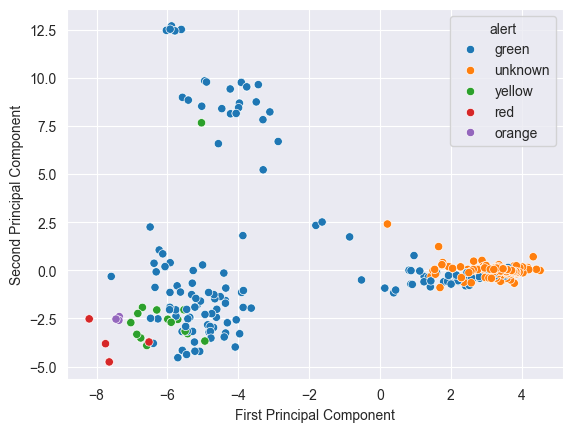

In [8]:
# Data visualization (2d scatter plot) 
pc1 = x_data_pca[:, 0]
pc2 = x_data_pca[:, 1]
# Creat scatter plot
plot = sns.scatterplot(x=pc1, y=pc2, hue=y_data)
# Rename axis
plot.set(xlabel="First Principal Component", ylabel="Second Principal Component")
plt.show()

In [9]:
# Dimensionality reduction
# Using LDA method
lda = LDA(n_components=2)
x_data_lda = lda.fit_transform(x_data, y_data)

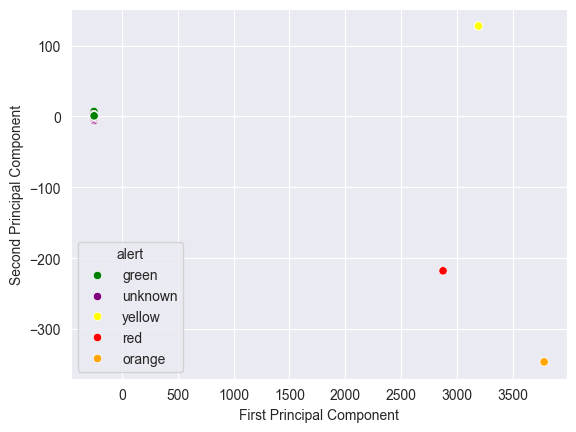

In [10]:
# Data visualization (2d scatter plot) 
pc1 = x_data_lda[:, 0]
pc2 = x_data_lda[:, 1]
# Creat scatter plot
custom_palette = {'red': "red", 'yellow': "yellow", 'green': "green", 'unknown': "purple", 'orange': "orange"}
plot_lda = sns.scatterplot(x=pc1, y=pc2, hue=y_data, palette=custom_palette)
# Rename axis
plot_lda.set(xlabel="First Principal Component", ylabel="Second Principal Component")
plt.show()

**Đánh giá các thành phần chính theo tham số thống kê** và **Xác định lượng thông tin được bảo tồn theo phương sai giải thích**

In [11]:
# Print the explained variance after reduce dimension of the data 
print(f'Explained variance: {np.cumsum(pca.explained_variance_)}')
# Print the statistic values of Principal Component
pd.DataFrame(data=x_data_pca,
             columns=['First Principal Component',
                      'Second Principal Component']).describe()

Explained variance: [17.07021591 27.18050268]


,First Principal Component,Second Principal Component
count,6.640000e+02,6.640000e+02
mean,5.136454e-16,6.420567e-17
std,4.131612e+00,3.179668e+00
min,-8.207969e+00,-4.756557e+00
25%,-4.822971e+00,-9.240485e-01
50%,2.500152e+00,-1.731444e-01
75%,3.497358e+00,1.182530e-02
max,4.522021e+00,1.269162e+01


**Thực hiện hiển thị trực quan đối với dữ liệu theo từng cặp 02 thành phần chính**

<Figure size 2000x2000 with 0 Axes>

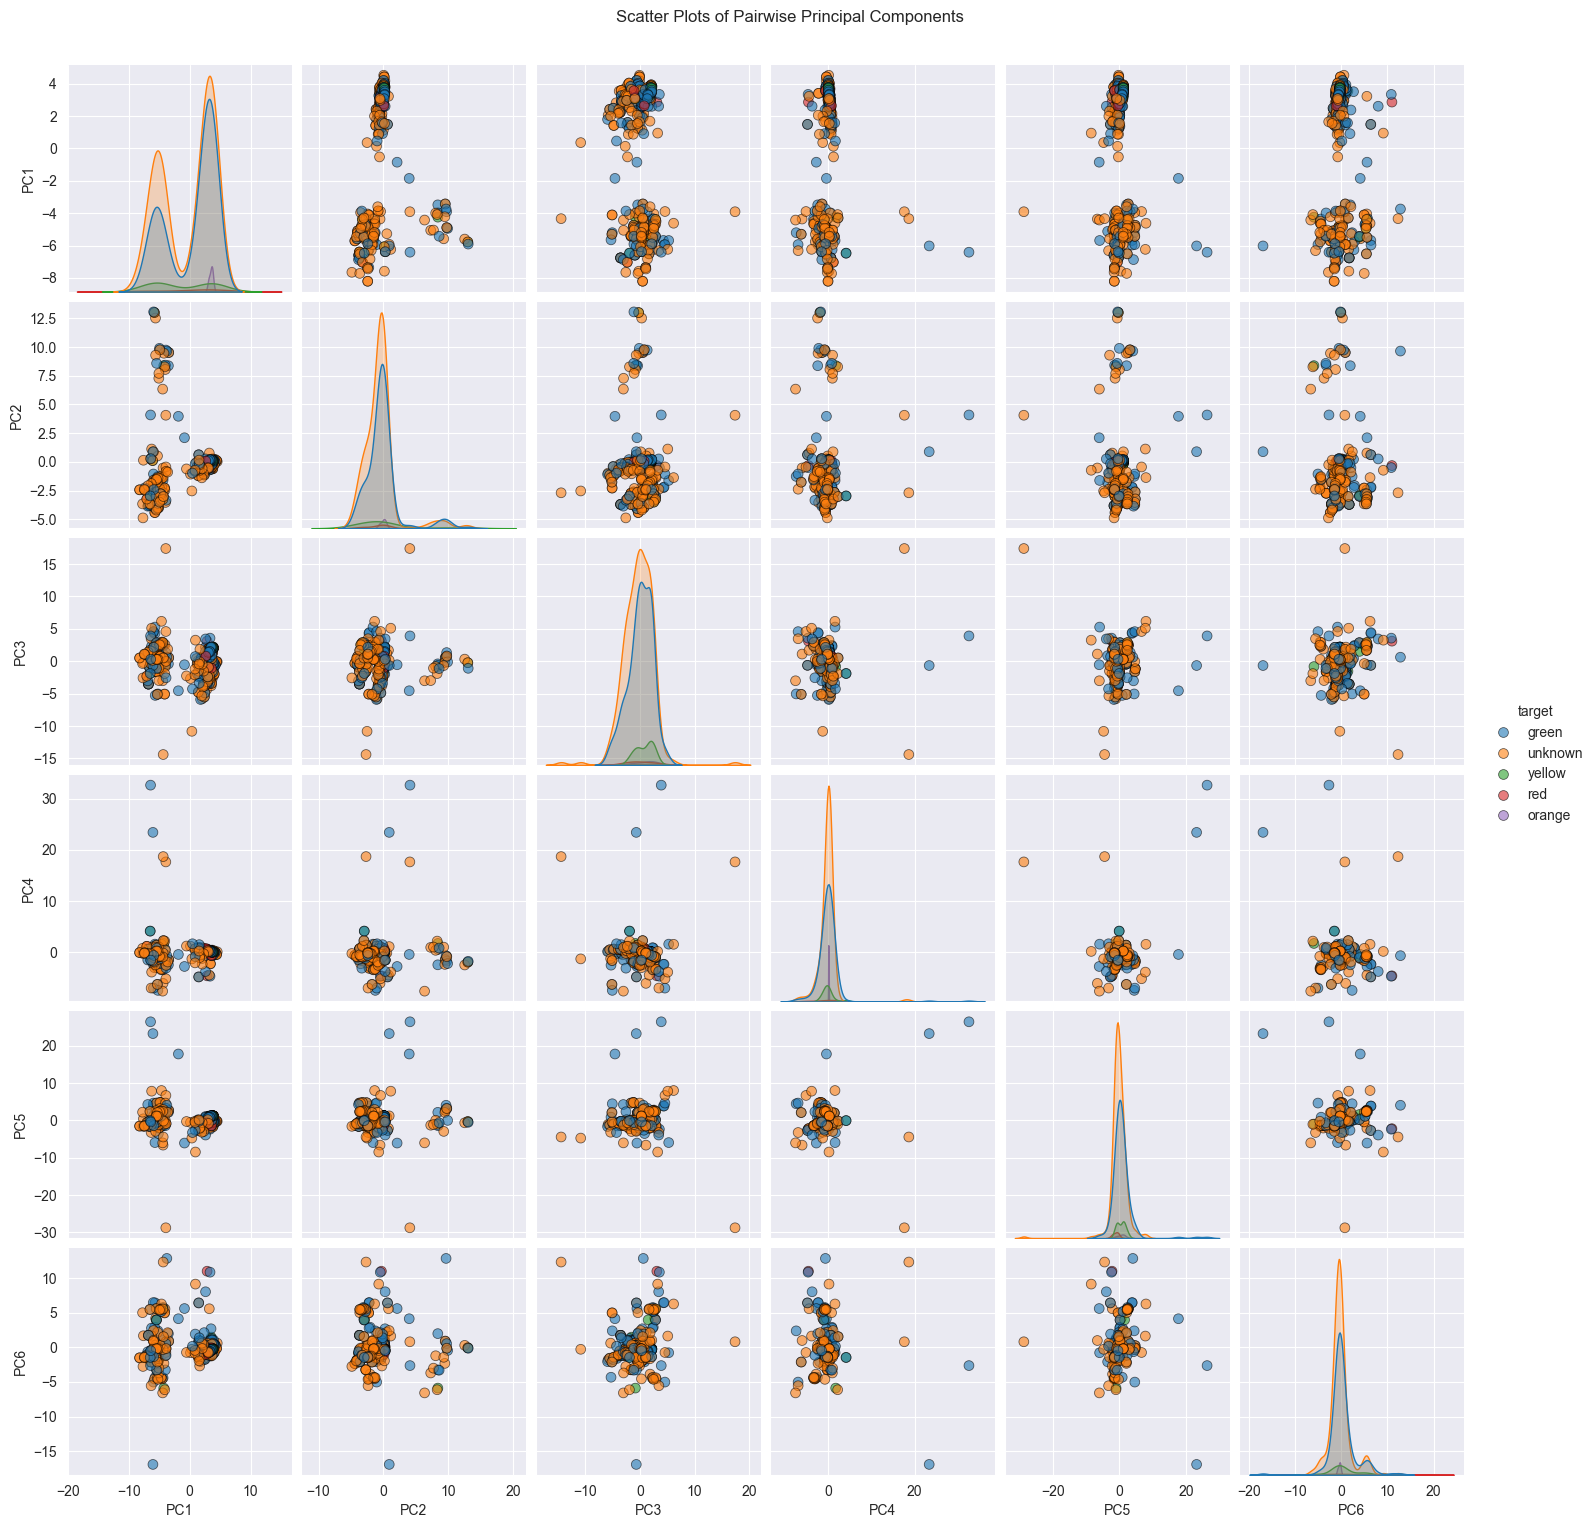

In [12]:
pca_pair = PCA(n_components=6)
X_pca = pca_pair.fit_transform(x_data)
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i + 1}' for i in range(6)])
df_pca['target'] = y_data
plt.figure(figsize=(20, 20))
sns.pairplot(df_pca, hue='target', diag_kind='kde',
             plot_kws={'alpha': 0.6, 's': 50, 'edgecolor': 'k'},
             vars=[f'PC{i + 1}' for i in range(6)])  # Sử dụng 4 thành phần chính
plt.suptitle("Scatter Plots of Pairwise Principal Components", y=1.02)
plt.show()

### GIẢM CHIỀU LDA

In [18]:
# Dimensionality reduction
# Using LDA method
lda_plot = LDA(n_components=3)
x_data_lda_plot = lda_plot.fit_transform(x_data, y_data)
# Data visualization (2d scatter plot) 
lda_x = x_data_lda_plot[:, 0]
lda_y = x_data_lda_plot[:, 1]
lda_z = x_data_lda_plot[:, 2]

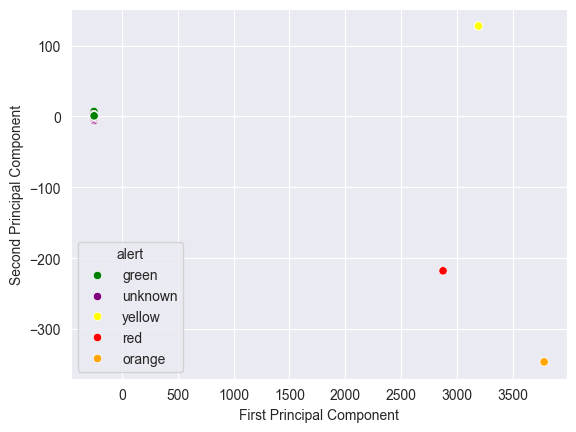

In [19]:
# Creat scatter plot
plot_lda = sns.scatterplot(x=lda_x, y=lda_y, hue=y_data, palette=custom_palette)
# Rename axis
plot_lda.set(xlabel="First Principal Component", ylabel="Second Principal Component")
plt.show()

PHÂN CỤM DỮ LIỆU

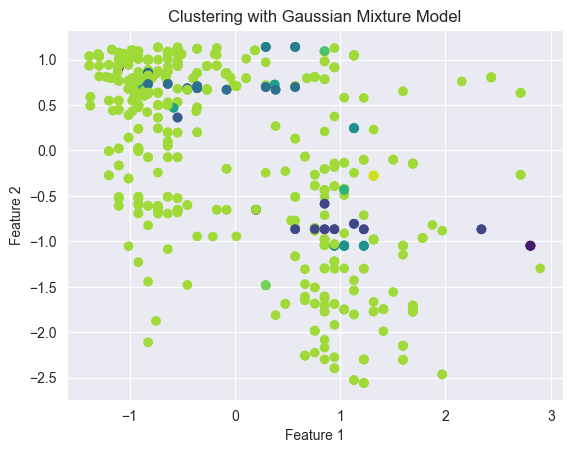

Silhouette Score: -0.11972975348954852
Davies-Bouldin Index: 1.6963229239791962
V-Measure: 0.13119926120163197
Adjusted Rand Index: 0.024401754578724608


In [15]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, adjusted_rand_score

# Create a copy of x_data to store the clustering results
x_data_gmm = np.copy(x_data)

# Train the model
gmm = GaussianMixture(n_components=15)
gmm.fit(x_data)

# Predict the labels
labels_gmm = gmm.predict(x_data)
x_data_gmm[:, 2] = labels_gmm  # Assign labels to the third column of x_data_gmm

# Visualize the results
plt.scatter(x_data_gmm[:, 0], x_data_gmm[:, 1], c=labels_gmm, cmap='viridis')
plt.title('Clustering with Gaussian Mixture Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

score = silhouette_score(x_data, labels_gmm)
print(f'Silhouette Score: {score}')

db_score = davies_bouldin_score(x_data, labels_gmm)
print(f'Davies-Bouldin Index: {db_score}')

v_score = v_measure_score(y_data, labels_gmm)
print(f'V-Measure: {v_score}')

ari_score = adjusted_rand_score(y_data, labels_gmm)
print(f'Adjusted Rand Index: {ari_score}')

Hàm để chia tập train test

In [16]:
# Function to split the training set and validation set
def split_data(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_data,
                                                        test_size=test_size,
                                                        random_state=42)
    return x_train, x_test, y_train, y_test

Các hàm thực hiện việc phân loại thuộc tính alert. Các phương pháp nhóm sử dụng
- Gaussian Naive Bayes Classifier
- Multinomial Logistic Regression (Softmax)
- Support Vector Machine with Soft Margins

In [17]:
def evaluate_model(start_time, end_time, y_test, y_pred):
    print(f'Training time: {end_time - start_time}s')
    print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
    print(f'Recall score: {recall_score(y_test, y_pred, average='macro')}')
    print(f'Precision score: {precision_score(y_test, y_pred, average='macro', zero_division=0)}')
    # print(classification_report(y_test, y_pred, zero_division=0))


# This function uses the Naive Bayes classifier approach
def naive_bayes_approach(x_train, x_test, y_train, y_test):
    # Train model
    start_time = time.perf_counter()
    model = GaussianNB()
    model.fit(x_train, y_train)
    end_time = time.perf_counter()

    # Predict the result
    y_pred = model.predict(x_test)

    # Evaluate the model
    evaluate_model(start_time, end_time, y_test, y_pred)


# This function uses the Multinomial Logistic Regression approach
def softmax_approach(x_train, x_test, y_train, y_test):
    # Train model
    start_time = time.perf_counter()
    model = LogisticRegression(max_iter=5000, solver='saga')
    model.fit(x_train, y_train)
    end_time = time.perf_counter()

    # Predict the result
    y_pred = model.predict(x_test)

    # Evaluate the model
    evaluate_model(start_time, end_time, y_test, y_pred)

Các hàm thực hiện phân loại theo 3 kịch bản:
- Thực hiện phân loại trên dữ liệu gốc (có chia thành các tập huấn luyện và kiểm tra)
- Thực hiện giảm chiều dữ liệu trước, rồi chia tập huấn luyện và kiểm tra rồi mới phân loại
- Thực hiện chia tập huấn luyện và kiểm tra trước, rồi giảm chiều dữ liệu rồi mới phân loại

In [25]:
def classification(x_train, x_test, y_train, y_test):
    print('Naive Bayes approach')
    naive_bayes_approach(x_train, x_test, y_train, y_test)
    print('\nSoftmax approach')
    softmax_approach(x_train, x_test, y_train, y_test)
    


# This function classifies based on the original data
def original_data(x_data, y_data, test_size):
    x_train, x_test, y_train, y_test = split_data(x_data, y_data, test_size)
    print(f'Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: {int((1 - test_size) * 10)}:{int(test_size * 10)}')
    classification(x_train, x_test, y_train, y_test)


# This function first reduces dimensionality, then splits the data into train and validation sets, and finally classifies
def dim_reduction_split(x_data, y_data, test_size, dim_reduction_type, dim):
    if (dim_reduction_type == 'pca'):
        pca = PCA(n_components=dim, random_state=42)
        x_data_dim_reduction = pca.fit_transform(x_data)
    elif (dim_reduction_type == 'lda'):
        lda = LDA(n_components=dim)
        x_data_dim_reduction = lda.fit_transform(x_data, y_data)

    x_train, x_test, y_train, y_test = split_data(x_data_dim_reduction, y_data, test_size)
    print(f'Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: {int((1 - test_size) * 10)}:{int(test_size * 10)}')
    classification(x_train, x_test, y_train, y_test)


# This function first splits the data into train and validation sets, then reduces dimensionality, and finally classifies
def split_dim_reduction(x_data, y_data, test_size, dim_reduction_type, dim):
    x_train, x_test, y_train, y_test = split_data(x_data, y_data, test_size)

    if (dim_reduction_type == 'pca'):
        pca = PCA(n_components=dim, random_state=42)
        x_train_dim_reduction = pca.fit_transform(x_train)
        x_test_dim_reduction = pca.transform(x_test)
    elif (dim_reduction_type == 'lda'):
        lda = LDA(n_components=dim)
        x_train_dim_reduction = lda.fit_transform(x_train, y_train)
        x_test_dim_reduction = lda.transform(x_test)

    print(f'Phân loại dựa trên dữ liệu được chia tỷ lệ train:test là: {int((1 - test_size) * 10)}:{int(test_size * 10)} rồi giảm chiều')
    classification(x_train_dim_reduction, x_test_dim_reduction, y_train, y_test)

Giảm còn $\dfrac{1}{3}$ số chiều 

In [26]:
dim_pca = x_data.shape[1] // 3
dim_lda = len(set(y_data)) // 3

### Thực hiện giảm chiều trên dữ liệu gốc
Tỷ lệ train test là 4:1

In [27]:
original_data(x_data, y_data, test_size=0.2)

Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: 8:2
Naive Bayes approach
Training time: 0.05602819999330677s
Accuracy score: 0.849624060150376
Recall score: 0.840983606557377
Precision score: 0.8758802816901408

Softmax approach
Training time: 20.135087599992403s
Accuracy score: 0.8646616541353384
Recall score: 0.8473713962690785
Precision score: 0.5977777777777777


Tỷ lệ train test là 7:3

In [28]:
original_data(x_data, y_data, test_size=0.3)

Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: 7:3
Naive Bayes approach
Training time: 0.012134600008721463s
Accuracy score: 0.845
Recall score: 0.8355555555555556
Precision score: 0.8679197994987469

Softmax approach
Training time: 15.982413599995198s
Accuracy score: 0.845
Recall score: 0.8357706093189965
Precision score: 0.5735897435897435


Tỷ lệ train test là 6:4

In [29]:
original_data(x_data, y_data, test_size=0.4)

Phân loại dựa trên dữ liệu gốc với tỷ lệ train:test là: 6:4
Naive Bayes approach
Training time: 0.010424400010379031s
Accuracy score: 0.8195488721804511
Recall score: 0.7975641025641026
Precision score: 0.8419110678351185

Softmax approach
Training time: 14.963787700005923s
Accuracy score: 0.8458646616541353
Recall score: 0.8411124896608767
Precision score: 0.5876392961876833


### Thực hiện trên dữ liệu giảm chiều PCA

Tỷ lệ train test là 4:1

In [30]:
dim_reduction_split(x_data, y_data, dim_reduction_type='pca', test_size=0.2, dim=dim_pca)

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 8:2
Naive Bayes approach
Training time: 0.010109300012118183s
Accuracy score: 0.7368421052631579
Recall score: 0.7909553420011306
Precision score: 0.6998496240601504

Softmax approach
Training time: 6.739633399993181s
Accuracy score: 0.8646616541353384
Recall score: 0.8473713962690785
Precision score: 0.5977777777777777


Tỷ lệ train test là 7:3

In [31]:
dim_reduction_split(x_data, y_data, dim_reduction_type='pca', test_size=0.3, dim=dim_pca)

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 7:3
Naive Bayes approach
Training time: 0.004428199987160042s
Accuracy score: 0.725
Recall score: 0.5873118279569892
Precision score: 0.4710544552649815

Softmax approach
Training time: 6.283116299993708s
Accuracy score: 0.845
Recall score: 0.8357706093189965
Precision score: 0.5735897435897435


Tỷ lệ train test là 6:4

In [32]:
dim_reduction_split(x_data, y_data, dim_reduction_type='pca', test_size=0.4, dim=dim_pca)

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 6:4
Naive Bayes approach
Training time: 0.0030193999991752207s
Accuracy score: 0.6879699248120301
Recall score: 0.6099834574028122
Precision score: 0.7622606516290726

Softmax approach
Training time: 5.2594219999882625s
Accuracy score: 0.8458646616541353
Recall score: 0.8411124896608767
Precision score: 0.5876392961876833


### Thực hiện trên dữ liệu giảm chiều LDA

Tỷ lệ train test là 4:1

In [33]:
dim_reduction_split(x_data, y_data, dim_reduction_type='lda', test_size=0.2, dim=dim_lda)

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 8:2
Naive Bayes approach
Training time: 0.0012200999917695299s
Accuracy score: 0.9323308270676691
Recall score: 0.9696438665912945
Precision score: 0.9698358800226373

Softmax approach
Training time: 0.10021790000610054s
Accuracy score: 0.5263157894736842
Recall score: 0.4
Precision score: 0.2310924369747899


Tỷ lệ train test là 7:3

In [34]:
dim_reduction_split(x_data, y_data, dim_reduction_type='lda', test_size=0.3, dim=dim_lda)

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 7:3
Naive Bayes approach
Training time: 0.0009474999969825149s
Accuracy score: 0.925
Recall score: 0.9673118279569893
Precision score: 0.9673118279569893

Softmax approach
Training time: 0.07429260000935756s
Accuracy score: 0.505
Recall score: 0.4
Precision score: 0.22777242044358728


Tỷ lệ train test là 6:4

In [35]:
dim_reduction_split(x_data, y_data, dim_reduction_type='lda', test_size=0.4, dim=dim_lda)

Phân loại dựa trên dữ liệu giảm chiều rồi chia tỷ lệ train:test là: 6:4
Naive Bayes approach
Training time: 0.001597599999513477s
Accuracy score: 0.9135338345864662
Recall score: 0.9623118279569892
Precision score: 0.9622791103944097

Softmax approach
Training time: 0.0842862999998033s
Accuracy score: 0.5
Recall score: 0.4
Precision score: 0.2165424739195231
